### Problem Description
Insurance companies take risks over customers. Risk management is a very important aspect of the insurance industry. Insurers consider every quantifiable factor to develop profiles of high and low insurance risks. Insurers collect vast amounts of information about policyholders and analyze the data.

As a Data scientist in an insurance company, you need to analyze the available data and predict whether to sanction the insurance or not.

### Dataset Description
A zipped file containing train, test and sample submission files are given. The training dataset consists of data corresponding to 52310 customers and the test dataset consists of 22421 customers. Following are the features of the dataset

Target: Claim Status (Claim)

Name of agency (Agency)

Type of travel insurance agencies (Agency.Type)

Distribution channel of travel insurance agencies (Distribution.Channel)

Name of the travel insurance products (Product.Name)

Duration of travel (Duration)

Destination of travel (Destination)

Amount of sales of travel insurance policies (Net.Sales)

The commission received for travel insurance agency (Commission)

Age of insured (Age)

The identification record of every observation (ID)

Evaluation Metric
The evaluation metric for this task will be precision_score. Read up about it more here.

### Submission Format
The user has to submit a csv file with the ID and Claim label. Sample submission file has been given to you. You can refer the sample submission file.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier ,GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,roc_curve,confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns',None)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
path = 'CleanedData.csv'

# Load the dataframe
data = pd.read_csv(path,delimiter=',')

# Remove the Id column from the dataset
# data.drop('Id',axis=1,inplace=True)

print('Shape of the data is: ',data.shape)

data.head()

Shape of the data is:  (52310, 13)


,Unnamed: 0,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim,Age_type
0,0,2010,EPX,Travel Agency,Online,Cancellation Plan,61,PHILIPPINES,12.0,0.00,41,0,Youth
1,1,4245,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,17.0,0.00,35,0,Youth
2,2,9251,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,26,THAILAND,19.8,11.88,47,0,Youth
3,3,4754,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,HONG KONG,27.0,0.00,48,0,Youth
4,4,8840,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,MALAYSIA,37.0,0.00,36,0,Youth


In [3]:
data.drop(['Unnamed: 0','ID','Age'],1, inplace = True)

In [4]:
col = data.columns.tolist()
col.remove('Claim')
col.append('Claim')
data = data[col]

In [5]:
data.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age_type,Claim
0,EPX,Travel Agency,Online,Cancellation Plan,61,PHILIPPINES,12.0,0.00,Youth,0
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,17.0,0.00,Youth,0
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,26,THAILAND,19.8,11.88,Youth,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,HONG KONG,27.0,0.00,Youth,0
4,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,MALAYSIA,37.0,0.00,Youth,0


In [17]:
#Check for Class Imbalance
def class_imbalance(target):
    class_values = (target.value_counts()/target.value_counts().sum())*100
    return class_values

class_imbalance(data['Claim'])

0    83.330147
1    16.669853
Name: Claim, dtype: float64

In [18]:
data['Claim'].value_counts()/data['Claim'].value_counts().sum()

0    0.833301
1    0.166699
Name: Claim, dtype: float64

In [19]:
le = LabelEncoder()
# Function that auto encodes any dataframe column of type category or object.
def dummyEncode(dataset):
        
        columnsToEncode = list(dataset.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                dataset[feature] = le.fit_transform(dataset[feature])
            except:
                print('Error encoding '+feature)
        return dataset
data = dummyEncode(data)


In [20]:
# Predictors
X = data.iloc[:,:-1]

# Target
y = data.iloc[:,-1]

In [21]:
# Find features with correlation nlargest
for k in range(4,11):
    cols=data.corr().nlargest(k,'Claim')['Claim'].index
    print(len(cols.tolist()),':',cols.tolist())

4 : ['Claim', 'Net Sales', 'Commision (in value)', 'Duration']
5 : ['Claim', 'Net Sales', 'Commision (in value)', 'Duration', 'Destination']
6 : ['Claim', 'Net Sales', 'Commision (in value)', 'Duration', 'Destination', 'Age_type']
7 : ['Claim', 'Net Sales', 'Commision (in value)', 'Duration', 'Destination', 'Age_type', 'Distribution Channel']
8 : ['Claim', 'Net Sales', 'Commision (in value)', 'Duration', 'Destination', 'Age_type', 'Distribution Channel', 'Product Name']
9 : ['Claim', 'Net Sales', 'Commision (in value)', 'Duration', 'Destination', 'Age_type', 'Distribution Channel', 'Product Name', 'Agency Type']
10 : ['Claim', 'Net Sales', 'Commision (in value)', 'Duration', 'Destination', 'Age_type', 'Distribution Channel', 'Product Name', 'Agency Type', 'Agency']


In [22]:
def feature_selection(predictors,target,number_of_features,model):

    models = model()
    rfe = RFE(models,number_of_features)
    rfe = rfe.fit(X,y)
    feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
    plt.show()
    print('Features  to be selected for {} are:'.format(str(i[0])))
    print(feature_ranking[feature_ranking.values==1].index.tolist())
    print('===='*30)

# Choosing the models. If you want to specify additional models, kindly specify them as a key-value pair as shown below.
models = {'Logistic Regression':LogisticRegression,'Random Forest':RandomForestClassifier,'XGBoost':XGBClassifier}

# Selecting 8 number of features
for i in models.items():
    feature_selection(X,y,5,i[1])
    


Features  to be selected for Logistic Regression are:
['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Age_type']
Features  to be selected for Random Forest are:
['Agency', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)']
Features  to be selected for XGBoost are:
['Agency', 'Product Name', 'Destination', 'Net Sales', 'Commision (in value)']


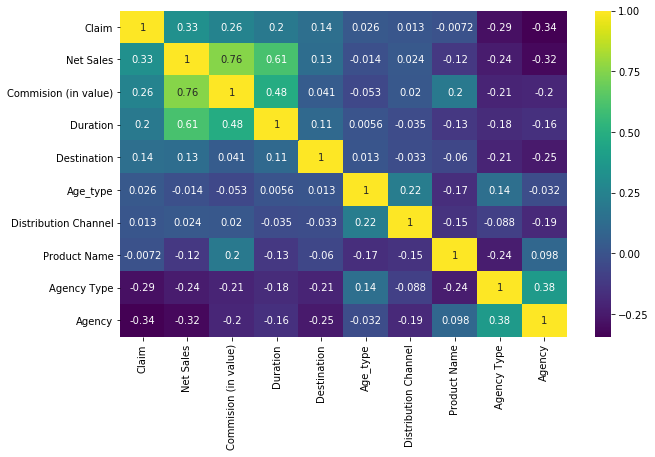

In [23]:
k=10
cols=data.corr().nlargest(k,'Claim')['Claim'].index
cm = data[cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, cmap='viridis')
plt.show()

In [24]:
def run_model(predictors,target, model):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    x_train,x_val,y_train,y_val = train_test_split(predictors,target,test_size=0.2,random_state=42)
    model.fit(x_train, y_train)
    y_scores = model.predict(x_val)
    auc = roc_auc_score(y_val, y_scores)

    print('Classification Report:')
    print(classification_report(y_val,y_scores))
    print('AUC Score = %.2f' %(auc*100) +' %')
    print('===='*20)

# Choosing the models. If you want to specify additional models, kindly specify them as a key-value pair as shown below.
models = {'Logistic Regression':LogisticRegression,'Decision Tree':DecisionTreeClassifier,'Random Forest': RandomForestClassifier,'XGBoost':XGBClassifier,'Gradient Boosting':GradientBoostingClassifier}

for i in models.items():
    # run model
    model = i[1]()
    print('On Model -  '+str(i[0]))
    run_model(X, y, model) # train and returns AUC test score

On Model -  Logistic Regression
Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.97      0.91      8696
          1       0.60      0.21      0.31      1766

avg / total       0.81      0.84      0.81     10462

AUC Score = 58.89 %
On Model -  Decision Tree
Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.95      0.95      8696
          1       0.76      0.74      0.75      1766

avg / total       0.92      0.92      0.92     10462

AUC Score = 84.43 %
On Model -  Random Forest
Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.96      0.96      8696
          1       0.81      0.74      0.77      1766

avg / total       0.92      0.93      0.92     10462

AUC Score = 85.22 %
On Model -  XGBoost
Classification Report:
             precision    recall  f1-score   support

          0       0.88      0.95      0.92   

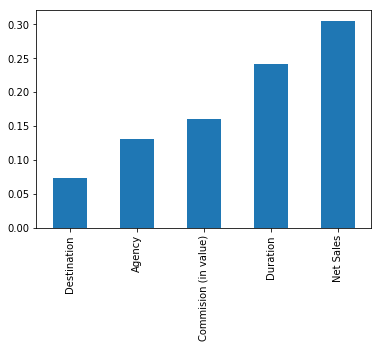

Index(['Destination', 'Agency', 'Commision (in value)', 'Duration',
       'Net Sales'],
      dtype='object')


In [25]:
def rfc_feature_selection(dataset,target):
    X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.3, random_state=42, stratify=target)
    rfc = RandomForestClassifier(random_state=42)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    rfc_importances = pd.Series(rfc.feature_importances_, index=dataset.columns).sort_values().tail(5)
    rfc_importances.plot(kind='bar')
    plt.show()
    print(rfc_importances.index)

rfc_feature_selection(X,y)

In [26]:
#Grid Search for Random Forest
def grid_search_random_forrest(dataframe,target):

    x_train,x_val,y_train,y_val = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)
    rfc = RandomForestClassifier()
    param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }
    grid_search_model = GridSearchCV(rfc, param_grid=param_grid)
    grid_search_model.fit(x_train, y_train)
    print('Best Parameters are:')
    return grid_search_model.best_params_


grid_search_random_forrest(X,y)

Best Parameters are:


{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto'}

On Validation data
ROC_AUC_SCORE is 0.8292479196356124
             precision    recall  f1-score   support

          0       0.96      0.81      0.88     13081
          1       0.47      0.85      0.61      2612

avg / total       0.88      0.82      0.84     15693



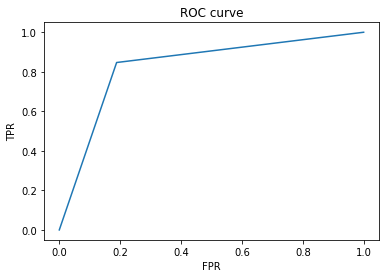

In [38]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report
from sklearn.model_selection import cross_val_score
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE


def grid_search_random_forrest_best(dataframe,target):
    
    
    x_train,x_val,y_train,y_val = train_test_split(dataframe,target, test_size=0.3, random_state=42)
    
    # Applying Smote on train data for dealing with class imbalance
    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(x_train, y_train)
    
    
    rfc = RandomForestClassifier(n_estimators=11, max_features='log2', max_depth=8, criterion='gini',random_state=42)
    rfc.fit(X_sm, y_sm)
    y_pred = rfc.predict(x_val)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    print('On Validation data')
    print('ROC_AUC_SCORE is',roc_auc_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
    #fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    
    



grid_search_random_forrest_best(X,y)

On Validation data
ROC_AUC_SCORE is 0.8154493974579171
             precision    recall  f1-score   support

          0       0.95      0.83      0.89     13081
          1       0.49      0.80      0.60      2612

avg / total       0.88      0.83      0.84     15693



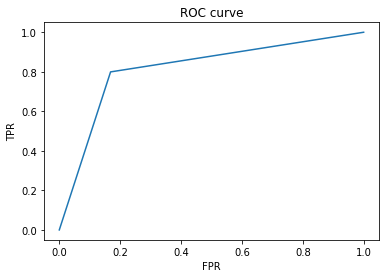

In [39]:
grid_search_random_forrest_best(X[['Destination', 'Agency', 'Commision (in value)', 'Duration',
       'Net Sales']],y)     # Applying the grid search function for random forest only on the best features obtained using Random Forest

On Validation data
ROC_AUC_SCORE is 0.8130807772937451
             precision    recall  f1-score   support

          0       0.95      0.83      0.88     13081
          1       0.48      0.80      0.60      2612

avg / total       0.87      0.82      0.84     15693



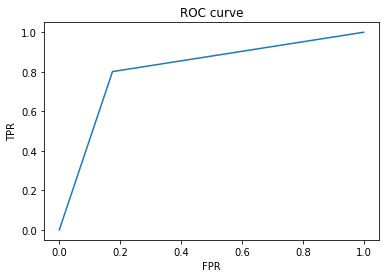

In [40]:
grid_search_random_forrest_best(X[['Agency', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)']],y)     # Applying the grid search function for random forest only on the best features obtained using RFE

Using Grid Search for Logistic Regression

On Validation Data
ROC_AUC_SCORE is  0.7447438758598357
             precision    recall  f1-score   support

          0       0.93      0.82      0.87     13081
          1       0.43      0.67      0.52      2612

avg / total       0.84      0.80      0.81     15693



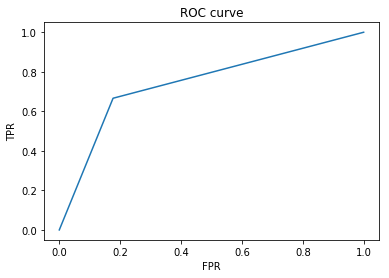

In [41]:
def grid_search_log_reg(dataframe,target):
    
    
    x_train,x_val,y_train,y_val = train_test_split(dataframe, target, test_size=0.3, random_state=42)

    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(x_train, y_train)
    
    
    log_reg = LogisticRegression()
    
    param_grid = { 
        'C' : np.logspace(-5, 8, 15)
    }
    grid_search = GridSearchCV(log_reg, param_grid=param_grid)
    
    grid_search.fit(X_sm, y_sm)
    y_pred = grid_search.predict(x_val)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    print('On Validation Data')
    print('ROC_AUC_SCORE is ',roc_auc_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    

grid_search_log_reg(X,y)

On Validation Data
ROC_AUC_SCORE is  0.8133991639792256
Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.81      0.88     13081
          1       0.46      0.82      0.59      2612

avg / total       0.87      0.81      0.83     15693

[[10598  2483]
 [  479  2133]]


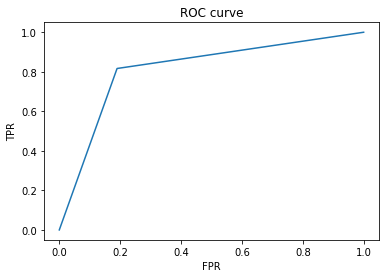

In [42]:
#Applying XGBoost model
def xgboost(dataframe,target):
    X = dataframe
    y = target

    x_train,x_val,y_train,y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(x_train, y_train)

    model = XGBClassifier(n_estimators=50, max_depth=4)
    model.fit(pd.DataFrame(X_sm,columns=x_train.columns), y_sm)
    y_pred = model.predict(x_val)
    
    print('On Validation Data')
    print('ROC_AUC_SCORE is ', roc_auc_score(y_val, y_pred))
    print('Classification Report:')
    print(classification_report(y_val, y_pred))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    #     print(auc(false_positive_rate, true_positive_rate))
    
    
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    print(confusion_matrix(y_val,y_pred))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    
xgboost(X,y)

On Validation Data
AUC_ROC_SCORE is (After Ensembling)  0.8665447167273109
Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.90      0.93     13081
          1       0.62      0.84      0.71      2612

avg / total       0.91      0.89      0.89     15693

[[11743  1338]
 [  430  2182]]


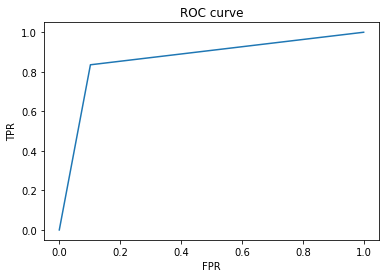

In [47]:
#Ensembling
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier


def ensemble_func2(dataframe,target):
    
    x_train,x_val,y_train,y_val = train_test_split(dataframe, target, test_size=0.3, random_state=42)

    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(x_train, y_train)
    
    
    model1 = RandomForestClassifier()
    model3 = GradientBoostingClassifier()
    model2 = LogisticRegression()
    
    model = VotingClassifier(estimators=[('rf', model1), ('lr', model2), ('xgb',model3)], voting='soft')
    model.fit(X_sm,y_sm)
    y_pred = model.predict(x_val)
    model.score(x_val,y_val)

        
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    print('On Validation Data')
    print('AUC_ROC_SCORE is (After Ensembling) ',roc_auc_score(y_val, y_pred))
    print('Classification Report:')
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    
ensemble_func2(X,y)

In [50]:
# Actual Test File
test = pd.read_csv('./data/test.csv')

# Storing the Id column
Id = test[['ID']]

# Preprocessed Test File
test = pd.read_csv('./data/sample_submission.csv')
# test.drop('ID',1,inplace=True)
test.head()

,ID,Claim
0,17631,1
1,15064,1
2,14139,1
3,19754,1
4,16439,1


In [52]:
def grid_search_log_reg(dataframe,target):


    x_train,x_val,y_train,y_val = train_test_split(dataframe, target, test_size=0.3, random_state=42)

    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(x_train, y_train)


    log_reg = LogisticRegression()

    param_grid = { 
        'C' : np.logspace(-5, 8, 15)
    }
    grid_search = GridSearchCV(log_reg, param_grid=param_grid)

    grid_search.fit(X_sm, y_sm)
    
    # Predict on the preprocessed test file
    y_pred = grid_search.predict(test)
    return y_pred

y_pred = grid_search_log_reg(X,y)


ValueError: X has 2 features per sample; expecting 9

In [ ]:
prediction = pd.DataFrame(y_pred, columns=['y'])
submission = pd.concat([Id,prediction['y']],1)

submission.to_csv('../data/submission.csv',index=False)

In [3]:
a= [4.2,6.2,8.2,0.2]
min(a)

0.2